In [1]:
import pandas as pd
import numpy as np
import xarray as xr
import xesmf as xe
pd.set_option('display.max_columns', None)

import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['savefig.dpi'] = 400
%config InlineBackend.figure_format = 'retina'

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
import warnings
warnings.filterwarnings("ignore")

import os
from os import listdir
# os.environ["NUMBA_NUM_THREADS"] = "1"
import random
random.seed(42)
np.random.seed(42)

## ERA5 - training

In [2]:
dir = os.path.dirname(os.path.abspath('__file__')) # os.path.abspath('')
data_path = os.path.join(dir, '../data/raw')
pro_data_path = os.path.join(data_path, '../processed')

years = [str(y) for y in range(1950, 1981)]  # Match paper's 1950-1980 period
months = [f"{m:02d}" for m in range(1, 13)]  # All 12 months
days = [f"{d:02d}" for d in range(1, 32)]  # 1-31 days
times = ["00:00"]  # Daily data at midnight

# Define region [N, W, S, E]
area = [75, -65, 30, 45]  # Matches the paper's study region

slp_path = os.path.join(data_path, 'slp')
z500_path = os.path.join(data_path, 'z500')

In [3]:
def Regrid(dirpath, years, outpath, type, grid=5):
    """ Regrid data and combine all years together. """

    if type == 'slp':
        var_name = 'msl'
    elif type == 'z500':
        var_name = 'z'

    lat_values = np.arange(30, 75+grid, grid)  # Latitude range
    lon_values = np.arange(-65, 45+grid, grid)  # Longitude range
    grid_5deg = xr.Dataset(
            {
                "lat": (["lat"], lat_values), # 10
                "lon": (["lon"], lon_values), # 23
            }
        )
    lon_grid, lat_grid = np.meshgrid(lon_values, lat_values)
    ds_full = []
    for y in years:
        data = xr.open_dataset(os.path.join(dirpath, f"{y}_era5_{type}.nc"))
        data = data.rename({"valid_time": "time", "latitude": "lat", "longitude": "lon"})
        data_time = data['time']
        data = data.sortby("lat")
        data = data.sortby("lon")

        # Create the regridder with bilinear interpolation
        regridder = xe.Regridder(data, grid_5deg, "bilinear", reuse_weights=False)
        regridded_data = regridder(data[var_name])

        ds = xr.Dataset(
            data_vars=dict(
                data=(["time", "rlat", "rlon"], regridded_data.values)
            ),
            coords=dict(
                lon=(["rlat", "rlon"], lon_grid),
                lat=(["rlat", "rlon"], lat_grid),
                time=data_time.values
            ),
            attrs=dict(description="ERA5_downsized")
        )

        ds_full.append(ds)
    data_full = xr.concat(ds_full, dim='time')
    data_full.to_netcdf(os.path.join(outpath, f"era5_{type}.nc"))
    return data_full

In [4]:
# Regrid and combine all years
slp = Regrid(slp_path, years, pro_data_path, "slp")
z500 = Regrid(z500_path, years, pro_data_path, "z500")

In [5]:
# Check if time is sorted and if there are any missing dates
i = 0
for time_array in [slp["time"].values, z500["time"].values]:
    if i == 0:
        print("slp:")
    else:
        print("z500:")
    i += 1
    is_sorted = np.all(time_array[:-1] <= time_array[1:])
    print(f"Time is sorted: {is_sorted}")
    expected_dates = pd.date_range(start="1950-01-01", end="1980-12-31", freq="D")
    actual_dates = pd.to_datetime(time_array)
    missing_dates = expected_dates.difference(actual_dates)
    if len(missing_dates) == 0:
        print("No missing dates. Every day is present.")
    else:
        print(f"Missing {len(missing_dates)} days:")
        print(missing_dates)

slp:
Time is sorted: True
No missing dates. Every day is present.
z500:
Time is sorted: True
No missing dates. Every day is present.


In [6]:
# Combine the two datasets
X = np.stack([slp['data'].values, z500['data'].values], axis=1) # Shape: (time, 2, lat, lon)
X.shape
start_date = "1950-01-01"
end_date = "1980-12-31"
date_range = pd.date_range(start=start_date, end=end_date, freq="D")
X.shape[0] == len(date_range)
np.save(os.path.join(pro_data_path, "combined_2channel_data.npy"), X)

(11323, 2, 10, 23)

True

In [7]:
# Load the labels
df_gwl = pd.read_csv(os.path.join(pro_data_path, "gwl_1940_1980.csv"))
df_gwl = df_gwl[df_gwl["year"] >= 1950].reset_index(drop=True)
df_gwl = df_gwl.sort_values(by=["year", "month"]).reset_index(drop=True)
df_gwl.shape[0] == 12 * (1980 - 1950 + 1)
df_gwl

True

,year,month,circ_type
0,1950,1,"['HM', 'NWZ', 'NWZ', 'NWZ', 'NWZ', 'NWZ', 'HM'..."
1,1950,2,"['SZ', 'SZ', 'SZ', 'SZ', 'WZ', 'WZ', 'WZ', 'WZ..."
2,1950,3,"['NEA', 'NEA', 'NEA', 'BM', 'BM', 'BM', 'BM', ..."
3,1950,4,"['WZ', 'WZ', 'TRM', 'TRM', 'TRM', 'TRM', 'TRM'..."
4,1950,5,"['HM', 'HM', 'NEZ', 'NEZ', 'NEZ', 'HNFZ', 'HNF..."
...,...,...,...
367,1980,8,"['SA', 'SA', 'SA', 'WA', 'WA', 'WA', 'WA', 'U'..."
368,1980,9,"['HM', 'HM', 'HM', 'BM', 'BM', 'BM', 'BM', 'BM..."
369,1980,10,"['BM', 'BM', 'BM', 'BM', 'BM', 'WZ', 'WZ', 'WZ..."
370,1980,11,"['HFA', 'HFA', 'HNFA', 'HNFA', 'HNFA', 'HNFZ',..."


In [8]:
import ast
# Convert string representation of lists into actual lists
df_gwl["circ_type"] = df_gwl["circ_type"].apply(ast.literal_eval)
gwl_flattened = [gwl for sublist in df_gwl["circ_type"] for gwl in sublist]
print(len(gwl_flattened))
gwl_flattened = np.array(gwl_flattened)
np.save(os.path.join(pro_data_path, "gwl_1950_1980_lbl.npy"), gwl_flattened)

11323


In [9]:
# Deleted undefined values
valid_idx = gwl_flattened != "U"
if sum(valid_idx) == len(gwl_flattened):
    print("No undefined values.")
X_filtered = X[valid_idx, :, :, :]
labels = gwl_flattened[valid_idx]
num_classes = len(set(labels))
print(f"We have {num_classes} labels:")
print(set(gwl_flattened))
print(f"We have {sum(valid_idx)} valid data to use.")
valid_time  = date_range[valid_idx]

np.save(os.path.join(pro_data_path, "clean_2channel_data.npy"), X_filtered)
np.save(os.path.join(pro_data_path, "clean_gwl_1950_1980_lbl.npy"), labels)
np.save(os.path.join(pro_data_path, "clean_time_1950_1980.npy"), valid_time)

We have 29 labels:
{'HNA', 'TB', 'NEZ', 'HFZ', 'SWZ', 'NEA', 'NWA', 'SA', 'HM', 'NZ', 'HNFA', 'SEA', 'BM', 'HFA', 'HNFZ', 'TRM', 'WA', 'SWA', 'WS', 'HNZ', 'NWZ', 'HB', 'U', 'WZ', 'TM', 'SEZ', 'SZ', 'WW', 'TRW', 'NA'}
We have 11183 valid data to use.


In [ ]:
res_path = os.path.join(dir, '../results')
if not os.path.exists(res_path):
    os.makedirs(res_path)
plot_path = os.path.join(dir, '../figures')
if not os.path.exists(plot_path):
    os.makedirs(plot_path)

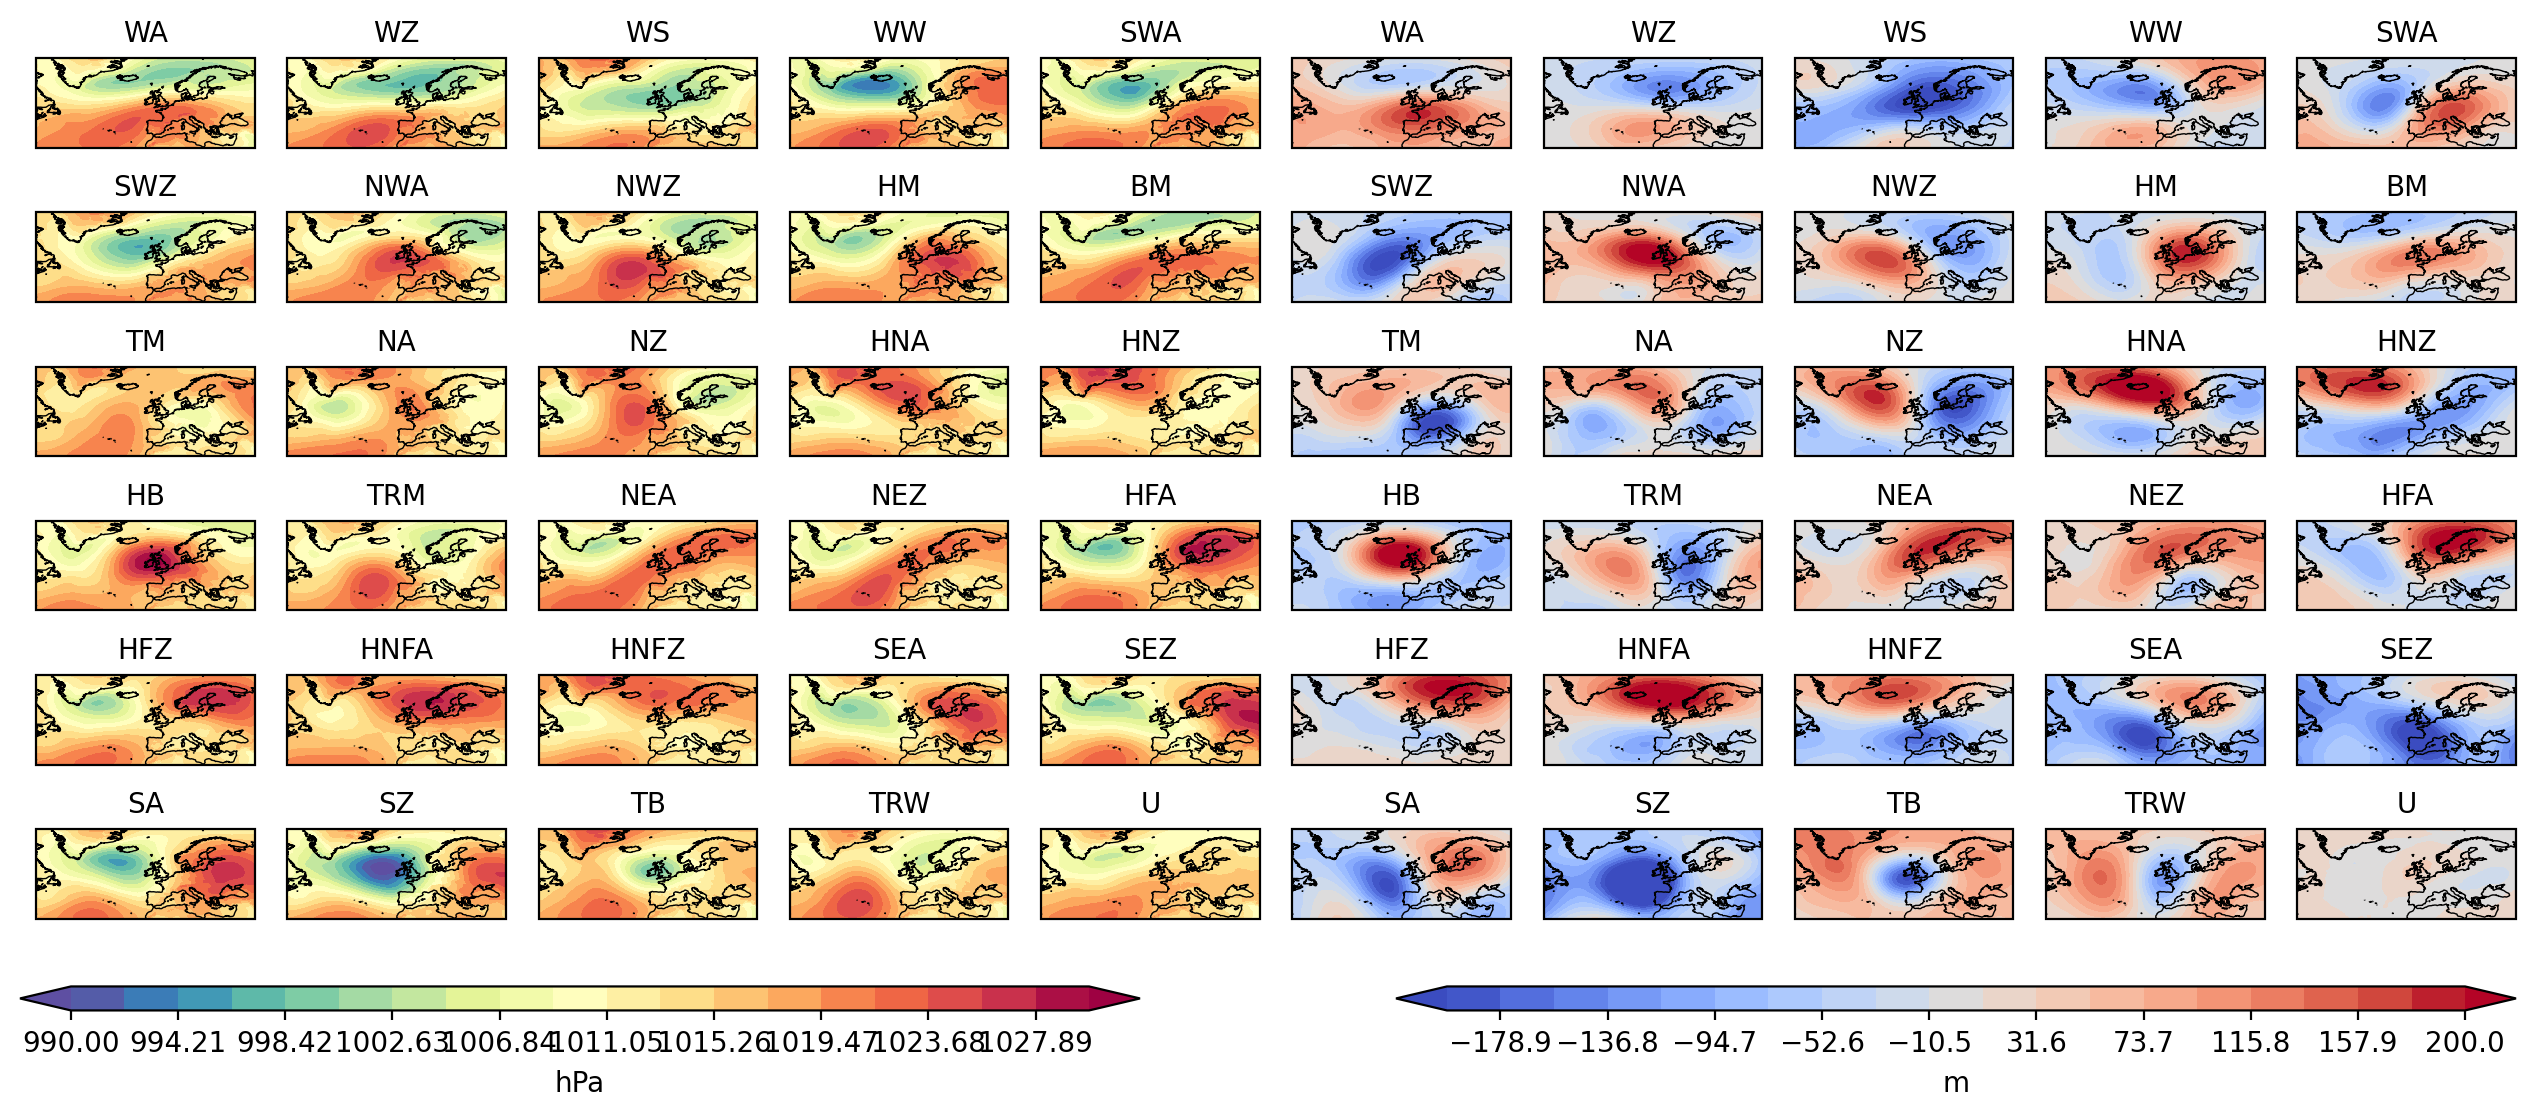

In [ ]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import seaborn as sns

# Load the non regridded orginal SLP and Z500 data
slp_ds = xr.open_dataset(os.path.join(data_path, "era5_slp.nc"))
z500_ds = xr.open_dataset(os.path.join(data_path, "era5_z500.nc"))

slp_ds["msl"] = slp_ds["msl"] / 100  # Convert Pa to hPa

# Load circulation types (assuming time-matching format)
hb_types = np.load(os.path.join(pro_data_path, "gwl_1950_1980_lbl.npy"), allow_pickle=True)

start_date = "1950-01-01"
end_date = "1980-12-31"
date_range = pd.date_range(start=start_date, end=end_date, freq="D")
df_hb = pd.DataFrame({"time": date_range, "type": hb_types})

# Compute climatological mean for Z500
z500_mean = z500_ds["z"].mean(dim="valid_time")
z500_std = z500_ds["z"].std(dim="valid_time")

# Unique circulation types
unique_types = [
    "WA", "WZ", "WS", "WW", "SWA", "SWZ", "NWA", "NWZ", "HM", "BM", 
    "TM", "NA", "NZ", "HNA", "HNZ", "HB", "TRM", "NEA", "NEZ", "HFA", 
    "HFZ", "HNFA", "HNFZ", "SEA", "SEZ", "SA", "SZ", "TB", "TRW", "U"
    ]


hb_type_da = xr.DataArray(df_hb["type"].values, coords=[slp_ds.valid_time], dims="valid_time")
# Compute mean SLP and Z500 anomaly for each circulation type
slp_means = {
    ctype: slp_ds["msl"].where(hb_type_da == ctype, drop=True).mean(dim="valid_time") for ctype in unique_types
}
z500_anomalies = {
    ctype: (200 * (z500_ds["z"].where(hb_type_da == ctype, drop=True) - z500_mean) / z500_std).mean(dim="valid_time")
    for ctype in unique_types
}


# Setup figure
num_types = len(unique_types)
ncols = 5
nrows = (num_types + ncols - 1) // ncols

fig, axes = plt.subplots(nrows, ncols * 2, figsize=(16, 6), subplot_kw={"projection": ccrs.PlateCarree()})
_= fig.subplots_adjust(hspace=0.01, wspace=0.15)

# Color maps
slp_cmap = sns.color_palette("Spectral_r", as_cmap=True)
z500_cmap = sns.color_palette("coolwarm", as_cmap=True)

for i, ctype in enumerate(unique_types):
    row, col = divmod(i, ncols)
    ax_slp = axes[row, col]     # Left column for SLP
    ax_z500 = axes[row, col + ncols]

    # Plot SLP
    im1 = ax_slp.contourf(slp_ds["longitude"], slp_ds["latitude"], slp_means[ctype], levels=np.linspace(990, 1030, 20), cmap=slp_cmap, extend="both")
    _= ax_slp.add_feature(cfeature.COASTLINE, linewidth=0.5)
    _= ax_slp.set_title(f"{ctype}", fontsize=10)

    # Plot Z500 anomaly
    im2 = ax_z500.contourf(z500_ds["longitude"], z500_ds["latitude"], z500_anomalies[ctype], levels=np.linspace(-200, 200, 20), cmap=z500_cmap, extend="both")
    _= ax_z500.add_feature(cfeature.COASTLINE, linewidth=0.5)
    _= ax_z500.set_title(f"{ctype}", fontsize=10)

# Add colorbars
cbar_ax1 = fig.add_axes([0.12, 0.06, 0.35, 0.02])
cbar_ax2 = fig.add_axes([0.55, 0.06, 0.35, 0.02])
cb1 = plt.colorbar(im1, cax=cbar_ax1, orientation="horizontal")
cb2 = plt.colorbar(im2, cax=cbar_ax2, orientation="horizontal")
_= cb1.set_label("hPa")
_= cb2.set_label("m")

plt.savefig(os.path.join(plot_path, "circulation_types.png"), bbox_inches="tight")
plt.show()

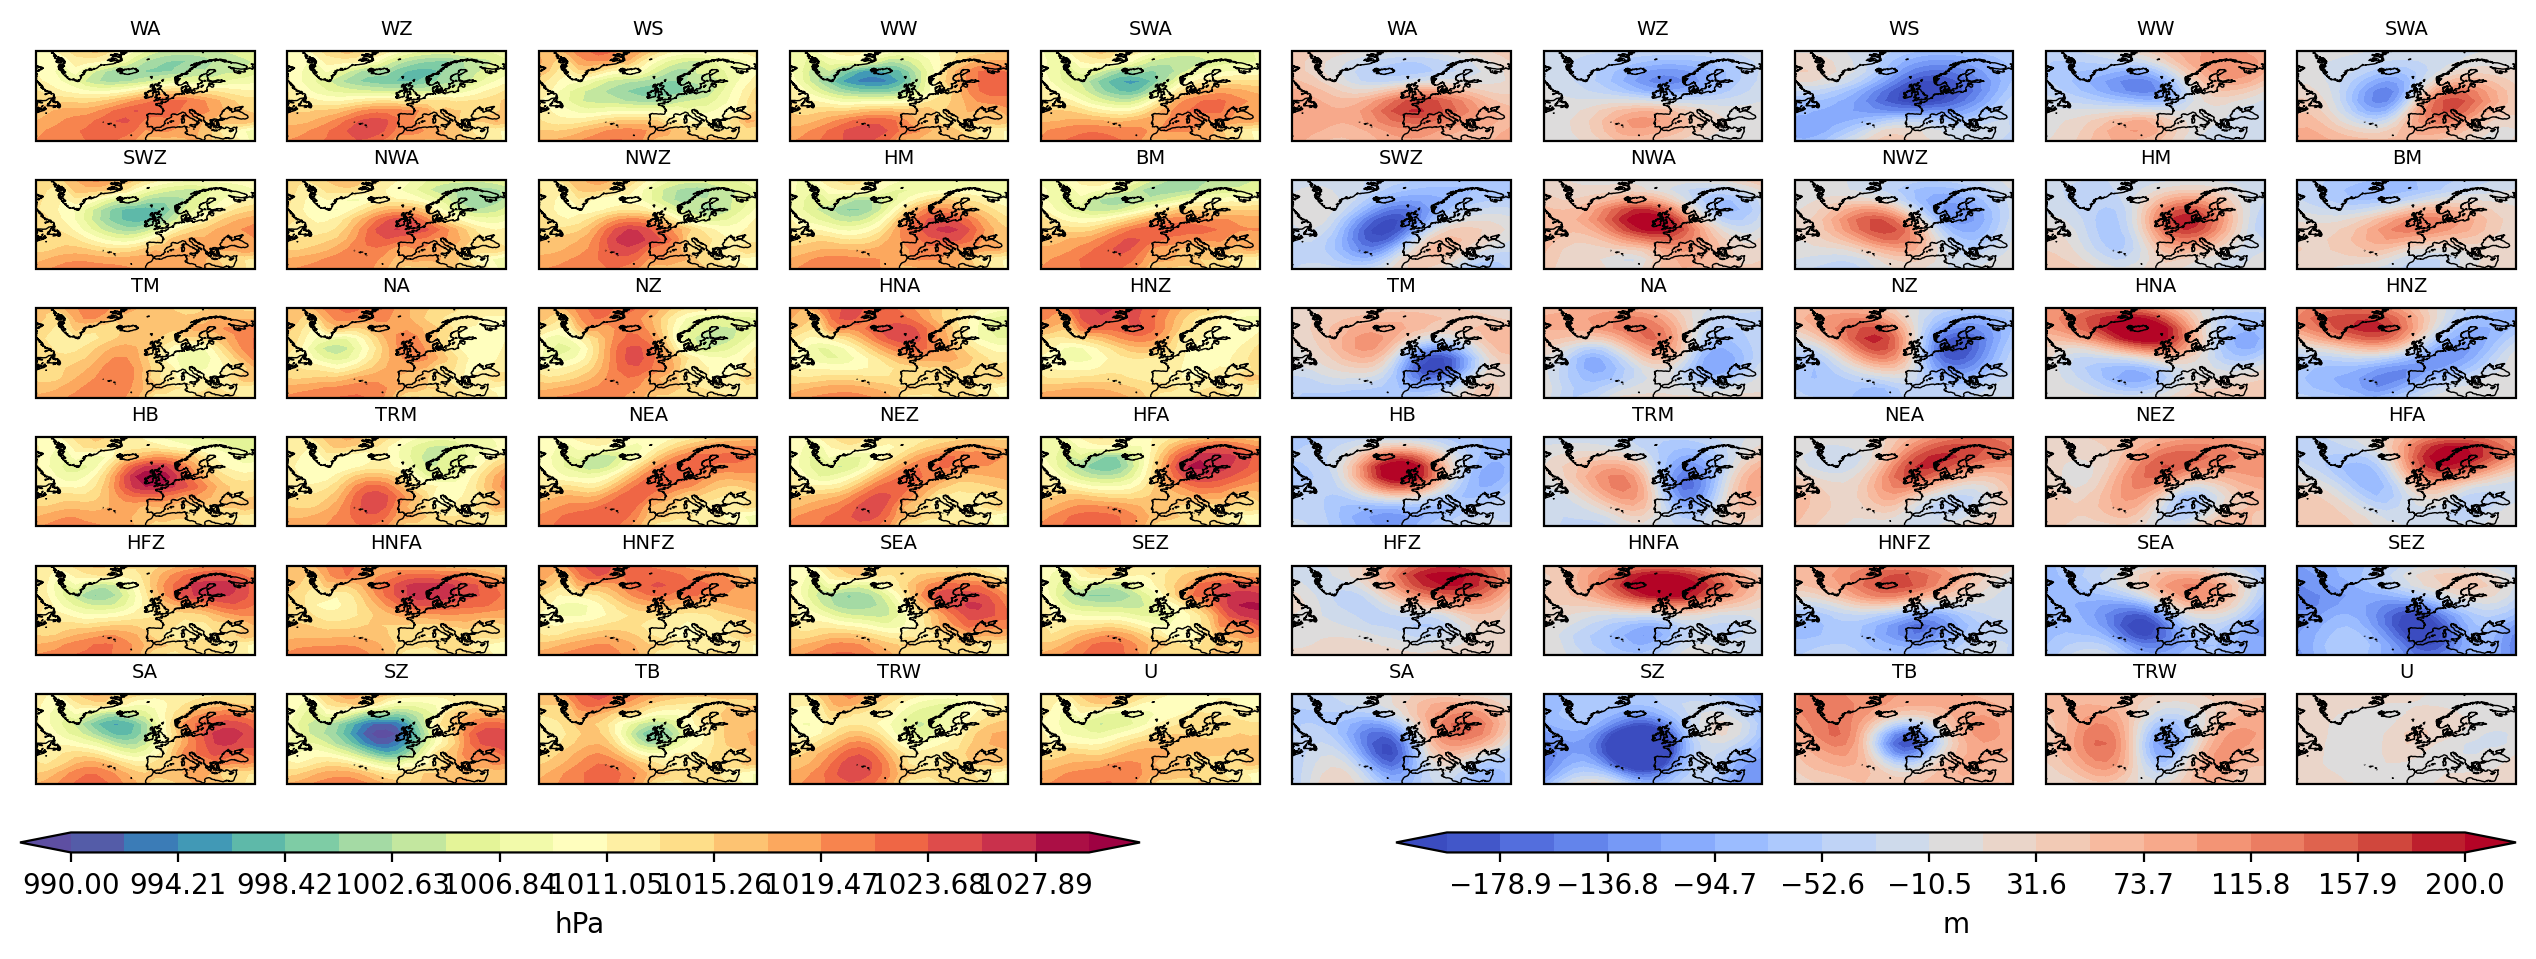

In [12]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import seaborn as sns

# Load the regridded SLP and Z500 data
slp_ds = xr.open_dataset(os.path.join(pro_data_path, "era5_slp.nc"))
z500_ds = xr.open_dataset(os.path.join(pro_data_path, "era5_z500.nc"))

slp_ds["data"] = slp_ds["data"] / 100  # Convert Pa to hPa

# Load circulation types (assuming time-matching format)
hb_types = np.load(os.path.join(pro_data_path, "gwl_1950_1980_lbl.npy"), allow_pickle=True)

start_date = "1950-01-01"
end_date = "1980-12-31"
date_range = pd.date_range(start=start_date, end=end_date, freq="D")
df_hb = pd.DataFrame({"time": date_range, "type": hb_types})

# Compute climatological mean for Z500
z500_mean = z500_ds["data"].mean(dim="time")
z500_std = z500_ds["data"].std(dim="time")

# Unique circulation types
unique_types = [
    "WA", "WZ", "WS", "WW", "SWA", "SWZ", "NWA", "NWZ", "HM", "BM", 
    "TM", "NA", "NZ", "HNA", "HNZ", "HB", "TRM", "NEA", "NEZ", "HFA", 
    "HFZ", "HNFA", "HNFZ", "SEA", "SEZ", "SA", "SZ", "TB", "TRW", "U"
    ]


hb_type_da = xr.DataArray(df_hb["type"].values, coords=[slp_ds.time], dims="time")
# Compute mean SLP and Z500 anomaly for each circulation type
slp_means = {
    ctype: slp_ds["data"].where(hb_type_da == ctype, drop=True).mean(dim="time") for ctype in unique_types
}
z500_anomalies = {
    ctype: (200 * (z500_ds["data"].where(hb_type_da == ctype, drop=True) - z500_mean) / z500_std).mean(dim="time")
    for ctype in unique_types
}


# Setup figure
num_types = len(unique_types)
ncols = 5
nrows = (num_types + ncols - 1) // ncols

fig, axes = plt.subplots(nrows, ncols * 2, figsize=(16, 5), subplot_kw={"projection": ccrs.PlateCarree()})
_= fig.subplots_adjust(hspace=0.01, wspace=0.15)

# Color maps
slp_cmap = sns.color_palette("Spectral_r", as_cmap=True)
z500_cmap = sns.color_palette("coolwarm", as_cmap=True)

for i, ctype in enumerate(unique_types):
    row, col = divmod(i, ncols)
    ax_slp = axes[row, col]     # Left column for SLP
    ax_z500 = axes[row, col + ncols]

    # Plot SLP
    im1 = ax_slp.contourf(slp_ds["lon"], slp_ds["lat"], slp_means[ctype], levels=np.linspace(990, 1030, 20), cmap=slp_cmap, extend="both")
    _= ax_slp.add_feature(cfeature.COASTLINE, linewidth=0.5)
    _= ax_slp.set_title(f"{ctype}", fontsize=7)

    # Plot Z500 anomaly
    im2 = ax_z500.contourf(z500_ds["lon"], z500_ds["lat"], z500_anomalies[ctype], levels=np.linspace(-200, 200, 20), cmap=z500_cmap, extend="both")
    _= ax_z500.add_feature(cfeature.COASTLINE, linewidth=0.5)
    _= ax_z500.set_title(f"{ctype}", fontsize=7)

# Add colorbars
cbar_ax1 = fig.add_axes([0.12, 0.06, 0.35, 0.02])
cbar_ax2 = fig.add_axes([0.55, 0.06, 0.35, 0.02])
cb1 = plt.colorbar(im1, cax=cbar_ax1, orientation="horizontal")
cb2 = plt.colorbar(im2, cax=cbar_ax2, orientation="horizontal")
_= cb1.set_label("hPa")
_= cb2.set_label("m")

plt.savefig(os.path.join(plot_path, "circulation_types_regrid.png"), bbox_inches="tight")
plt.show()

## CanESM2 - past & future compare
30 years gap: 1971-2020 past, 2031-2060 future

In [3]:
test_path = os.path.join(data_path, 'CanESM2')
pro_test_path = os.path.join(pro_data_path, 'CanESM2')
if not os.path.exists(pro_test_path):
    os.makedirs(pro_test_path)
historical = ['r1', 'r3', 'r5']
subsets = ['r2', 'r4', 'r6', 'r8']

slp_te_pth_1 = os.path.join(test_path, 'slp', "psl_day_CanESM2_historical-r1_r8i1p1_19500101-20201231.nc")
z500_te_pth_1 = []
for start_year in range(1971, 2001, 5):
    end_year = start_year + 4
    z_pth = os.path.join(test_path, 'z500', f"zg_day_CanESM2_historical-r1_r8i1p1_{start_year}0101-{end_year}1231.nc")
    z500_te_pth_1.append(z_pth)

slp_te_pth_2 = os.path.join(test_path, 'slp', "psl_day_CanESM2_historical-r1_r8i1p1_20210101-21001231.nc")
z500_te_pth_2 = []
for start_year in range(2031, 2061, 5):
    end_year = start_year + 4
    z_pth = os.path.join(test_path, 'z500', f"zg_day_CanESM2_historical-r1_r8i1p1_{start_year}0101-{end_year}1231.nc")
    z500_te_pth_2.append(z_pth)

In [12]:
def clean_pls_files(dirpath, his, sub, timec):
    if timec == 'future':
        timeslice = ("2031-01-01", "2060-12-31")
        dataset = xr.open_dataset(os.path.join(dirpath, 'slp', his, sub, f"psl_day_CanESM2_historical-{his}_{sub}i1p1_20210101-21001231.nc"))
    elif timec == 'past':
        timeslice = ("1971-01-01", "2000-12-31")
        dataset = xr.open_dataset(os.path.join(dirpath, 'slp', his, sub, f"psl_day_CanESM2_historical-{his}_{sub}i1p1_19500101-20201231.nc"))
    else:
        raise ValueError("Invalid time choice")
    
    dataset["time"] = np.array([np.datetime64(t.strftime('%Y-%m-%dT%H:%M:%S')) for t in dataset.time.values])
    dataset = dataset.sel(time=slice(timeslice[0], timeslice[1]))
    dataset = dataset.assign_coords(lon=((dataset.lon + 180) % 360 - 180))
    dataset = dataset.sortby("lon")
    dataset = dataset.sortby("lat")
    dataset = dataset.sel(lat=slice(30, 75)).sel(lon=slice(-65, 45))
    dataset.to_netcdf(os.path.join(dirpath, f"slp_{his}_{sub}_{timec}.nc"))
    return dataset

def clean_zg_files(dirpath, his, sub, timec):
    if timec == 'future':
        timeslice = (2031, 2061)
    elif timec == 'past':
        timeslice = (1971, 2001)
    else:
        raise ValueError("Invalid time choice")
    
    paths = []
    for start_year in range(timeslice[0], timeslice[1], 5):
        end_year = start_year + 4
        z_pth = os.path.join(dirpath, 'z500', his, sub, f"zg_day_CanESM2_historical-{his}_{sub}i1p1_{start_year}0101-{end_year}1231.nc")
        paths.append(z_pth)

    datasets = [xr.open_dataset(p) for p in paths]
    merged_ds = xr.concat(datasets, dim="time")
    merged_ds = merged_ds.sel(plev=50000)
    merged_ds["time"] = np.array([np.datetime64(t.strftime('%Y-%m-%dT%H:%M:%S')) for t in merged_ds.time.values])
    merged_ds = merged_ds.assign_coords(lon=((merged_ds.lon + 180) % 360 - 180))
    merged_ds['zg'] = merged_ds['zg'] * 10 # make sure same scale as ERA5
    merged_ds = merged_ds.sortby("lon")
    merged_ds = merged_ds.sortby("lat")
    merged_ds = merged_ds.sel(lat=slice(30, 75)).sel(lon=slice(-65, 45))
    merged_ds.to_netcdf(os.path.join(dirpath, f"z500_{his}_{sub}_{timec}.nc"))
    return merged_ds

In [ ]:
slp_past = {}
z500_past = {}
for his in historical:
    for sub in subsets:
        slp_past[his+'_'+sub] = clean_pls_files(test_path, his, sub, 'past')
        z500_past[his+'_'+sub] = clean_zg_files(test_path, his, sub, 'past')

slp_future = {}
z500_future = {}
for his in historical:
    for sub in subsets:
        slp_future[his+'_'+sub] = clean_pls_files(test_path, his, sub, 'future')
        z500_future[his+'_'+sub] = clean_zg_files(test_path, his, sub, 'future')

slp_past['r1_r2']
z500_past['r3_r4']
slp_future['r3_r6']
z500_future['r5_r8']

<xarray.Dataset> Size: 28MB
Dimensions:    (time: 10950, bnds: 2, lat: 16, lon: 40)
Coordinates:
  * time       (time) datetime64[ns] 88kB 1971-01-01T12:00:00 ... 2000-12-31T...
  * lat        (lat) float64 128B 32.09 34.88 37.67 40.46 ... 68.37 71.16 73.95
  * lon        (lon) float64 320B -64.69 -61.88 -59.06 ... 39.38 42.19 45.0
Dimensions without coordinates: bnds
Data variables:
    time_bnds  (time, bnds) object 175kB ...
    lat_bnds   (lat, bnds) float64 256B ...
    lon_bnds   (lon, bnds) float64 640B ...
    psl        (time, lat, lon) float32 28MB ...
Attributes: (12/31)
    institution:            CCCma (Canadian Centre for Climate Modelling and ...
    institute_id:           CCCma
    experiment_id:          historical-r1
    source:                 CanESM2
    model_id:               CanESM2
    forcing:                GHG,Oz,SA,BC,OC,LU,Sl,Vl (GHG includes CO2,CH4,N2...
    ...                     ...
    table_id:               Table day (22 March 2012) d12339b33194a0b329ded55...
    title:                  CanESM2 model output prepared for CanSISE histori...
    parent_experiment:      N/A
    modeling_realm:         atmos
    realization:            2
    cmor_version:           2.8.2

<xarray.Dataset> Size: 38MB
Dimensions:    (time: 10950, bnds: 2, lat: 16, lon: 40)
Coordinates:
  * time       (time) datetime64[ns] 88kB 1971-01-01T12:00:00 ... 2000-12-31T...
    plev       float64 8B 5e+04
  * lat        (lat) float64 128B 32.09 34.88 37.67 40.46 ... 68.37 71.16 73.95
  * lon        (lon) float64 320B -64.69 -61.88 -59.06 ... 39.38 42.19 45.0
Dimensions without coordinates: bnds
Data variables:
    time_bnds  (time, bnds) object 175kB 1971-01-01 00:00:00 ... 2001-01-01 0...
    plev_bnds  (time, bnds) float64 175kB 5e+04 2.5e+04 5e+04 ... 5e+04 2.5e+04
    lat_bnds   (time, lat, bnds) float64 3MB 30.7 33.49 33.49 ... 72.55 75.34
    lon_bnds   (time, lon, bnds) float64 7MB 293.9 296.7 296.7 ... 43.59 46.41
    zg         (time, lat, lon) float32 28MB 5.773e+04 5.791e+04 ... 5.094e+04
Attributes: (12/31)
    institution:            CCCma (Canadian Centre for Climate Modelling and ...
    institute_id:           CCCma
    experiment_id:          historical-r3
    source:                 CanESM2
    model_id:               CanESM2
    forcing:                GHG,Oz,SA,BC,OC,LU,Sl,Vl (GHG includes CO2,CH4,N2...
    ...                     ...
    table_id:               Table day (22 March 2012) dd825c156dfd950fc42a6d9...
    title:                  CanESM2 model output prepared for CanSISE histori...
    parent_experiment:      N/A
    modeling_realm:         atmos
    realization:            4
    cmor_version:           2.8.2

<xarray.Dataset> Size: 28MB
Dimensions:    (time: 10950, bnds: 2, lat: 16, lon: 40)
Coordinates:
  * time       (time) datetime64[ns] 88kB 2031-01-01T12:00:00 ... 2060-12-31T...
  * lat        (lat) float64 128B 32.09 34.88 37.67 40.46 ... 68.37 71.16 73.95
  * lon        (lon) float64 320B -64.69 -61.88 -59.06 ... 39.38 42.19 45.0
Dimensions without coordinates: bnds
Data variables:
    time_bnds  (time, bnds) object 175kB ...
    lat_bnds   (lat, bnds) float64 256B ...
    lon_bnds   (lon, bnds) float64 640B ...
    psl        (time, lat, lon) float32 28MB ...
Attributes: (12/31)
    institution:            CCCma (Canadian Centre for Climate Modelling and ...
    institute_id:           CCCma
    experiment_id:          historical-r3
    source:                 CanESM2
    model_id:               CanESM2
    forcing:                GHG,Oz,SA,BC,OC,LU,Sl,Vl (GHG includes CO2,CH4,N2...
    ...                     ...
    table_id:               Table day (22 March 2012) 8218c0c9f7f85a8b5bf8540...
    title:                  CanESM2 model output prepared for CanSISE histori...
    parent_experiment:      N/A
    modeling_realm:         atmos
    realization:            6
    cmor_version:           2.8.2

<xarray.Dataset> Size: 38MB
Dimensions:    (time: 10950, bnds: 2, lat: 16, lon: 40)
Coordinates:
  * time       (time) datetime64[ns] 88kB 2031-01-01T12:00:00 ... 2060-12-31T...
    plev       float64 8B 5e+04
  * lat        (lat) float64 128B 32.09 34.88 37.67 40.46 ... 68.37 71.16 73.95
  * lon        (lon) float64 320B -64.69 -61.88 -59.06 ... 39.38 42.19 45.0
Dimensions without coordinates: bnds
Data variables:
    time_bnds  (time, bnds) object 175kB 2031-01-01 00:00:00 ... 2061-01-01 0...
    plev_bnds  (time, bnds) float64 175kB 5e+04 2.5e+04 5e+04 ... 5e+04 2.5e+04
    lat_bnds   (time, lat, bnds) float64 3MB 30.7 33.49 33.49 ... 72.55 75.34
    lon_bnds   (time, lon, bnds) float64 7MB 293.9 296.7 296.7 ... 43.59 46.41
    zg         (time, lat, lon) float32 28MB 5.83e+04 5.836e+04 ... 5.229e+04
Attributes: (12/31)
    institution:            CCCma (Canadian Centre for Climate Modelling and ...
    institute_id:           CCCma
    experiment_id:          historical-r5
    source:                 CanESM2
    model_id:               CanESM2
    forcing:                GHG,Oz,SA,BC,OC,LU,Sl,Vl (GHG includes CO2,CH4,N2...
    ...                     ...
    table_id:               Table day (22 March 2012) 0545f1c3ae44938ae8db707...
    title:                  CanESM2 model output prepared for CanSISE histori...
    parent_experiment:      N/A
    modeling_realm:         atmos
    realization:            8
    cmor_version:           2.8.2

In [15]:
### one example to set gridded lat and lon
lat = slp_past['r1_r2']['lat'].values
lon = slp_past['r1_r2']['lon'].values
for his in historical:
    for sub in subsets:
        key = f"{his}_{sub}"
        slp_1 = slp_past[key]
        z500_1 = z500_past[key]
        slp_2 = slp_future[key]
        z500_2 = z500_future[key]

        for name, var in zip(
            ['slp_past', 'z500_past', 'slp_future', 'z500_future'],
            [slp_1, z500_1, slp_2, z500_2]
        ):
            lat_check = np.array_equal(var['lat'].values, lat)
            lon_check = np.array_equal(var['lon'].values, lon)

            if not lat_check or not lon_check:
                print(f"Mismatch in {name} for {key}.")

In [16]:
len(lat)
np.diff(lat)
len(lon)
np.diff(lon)

16

array([2.79057711, 2.79056864, 2.79055855, 2.79054649, 2.79053197,
       2.79051434, 2.79049271, 2.79046585, 2.790432  , 2.79038858,
       2.79033169, 2.79025521, 2.7901491 , 2.7899959 , 2.78976314])

40

array([2.8125, 2.8125, 2.8125, 2.8125, 2.8125, 2.8125, 2.8125, 2.8125,
       2.8125, 2.8125, 2.8125, 2.8125, 2.8125, 2.8125, 2.8125, 2.8125,
       2.8125, 2.8125, 2.8125, 2.8125, 2.8125, 2.8125, 2.8125, 2.8125,
       2.8125, 2.8125, 2.8125, 2.8125, 2.8125, 2.8125, 2.8125, 2.8125,
       2.8125, 2.8125, 2.8125, 2.8125, 2.8125, 2.8125, 2.8125])

In [17]:
binned_lat_idx = [0,1,2,3,5,7,9,11,13,15]
binned_lat = np.array([lat[i] for i in binned_lat_idx])
len(binned_lat) == 10

binned_lon_idx = [0,1,3,5,7,9,11,13,15,17,19,20,21,23,25,27,29,31,33,35,37,38,39]
binned_lon = np.array([lon[i] for i in binned_lon_idx])
len(binned_lon) == 23

True

True

In [18]:
def regrid_test(data, binned_lat, binned_lon, outpath, his, sub, type, timec):

    if type == 'slp':
        var_name = 'psl'
    elif type == 'z500':
        var_name = 'zg'

    lat_values = binned_lat  # Latitude range
    lon_values = binned_lon  # Longitude range
    grid_5deg = xr.Dataset(
            {
                "lat": (["lat"], lat_values), # 10
                "lon": (["lon"], lon_values), # 23
            }
        )
    lon_grid, lat_grid = np.meshgrid(lon_values, lat_values)
    data_time = data['time']
    regridder = xe.Regridder(data, grid_5deg, "bilinear", reuse_weights=False)
    regridded_data = regridder(data[var_name])

    ds = xr.Dataset(
        data_vars=dict(
            data=(["time", "rlat", "rlon"], regridded_data.values)
        ),
        coords=dict(
            lon=(["rlat", "rlon"], lon_grid),
            lat=(["rlat", "rlon"], lat_grid),
            time=data_time.values
        ),
        attrs=dict(description="CanESM_downsized")
    )

    ds.to_netcdf(os.path.join(outpath, f"{type}_{his}_{sub}_{timec}.nc"))
    return ds

In [19]:
for his in historical:
    for sub in subsets:
        key = f"{his}_{sub}"
        slp_1 = slp_past[key]
        z500_1 = z500_past[key]
        slp_2 = slp_future[key]
        z500_2 = z500_future[key]
        slp_past[key] = regrid_test(slp_1, binned_lat, binned_lon, pro_test_path, his, sub, "slp", "past")
        z500_past[key] = regrid_test(z500_1, binned_lat, binned_lon, pro_test_path, his, sub, "z500", "past")
        slp_future[key] = regrid_test(slp_2, binned_lat, binned_lon, pro_test_path, his, sub, "slp", "future")
        z500_future[key] = regrid_test(z500_2, binned_lat, binned_lon, pro_test_path, his, sub, "z500", "future")

In [23]:
### print to be familiar with data value scale, range etc.
slp = xr.open_dataset(os.path.join(pro_data_path, "era5_slp.nc"))
slp['data'].values[1:5, 1:5, 1:5]
slp_1['psl'].values[1:5, 1:5, 1:5]
slp_2['psl'].values[1:5, 1:5, 1:5]
z500 = xr.open_dataset(os.path.join(pro_data_path, "era5_z500.nc"))
z500['data'].values[1:5, 1:5, 1:5]
z500_1['zg'].values[1:5, 1:5, 1:5]
z500_2['zg'].values[1:5, 1:5, 1:5]

array([[[102694.94, 102262.56, 101763.56, 101149.69],
        [102912.69, 102377.44, 101796.81, 100918.19],
        [102995.06, 102672.69, 101990.31, 100984.94],
        [102820.19, 102331.19, 102033.69, 101227.94]],

       [[102942.56, 102738.81, 102450.06, 102053.06],
        [103200.31, 103116.56, 102816.31, 102052.06],
        [103300.56, 103270.81, 103031.06, 102313.31],
        [102456.81, 102372.56, 102519.06, 102162.81]],

       [[103203.94, 103173.94, 103047.94, 102666.19],
        [102992.19, 103460.44, 103565.69, 103189.19],
        [102621.19, 103271.94, 103479.44, 103163.94],
        [102463.44, 103114.19, 103166.94, 102474.94]],

       [[103378.56, 103377.31, 103331.06, 103008.06],
        [102466.31, 102797.81, 103112.31, 103265.81],
        [101078.31, 101277.81, 101950.06, 102637.31],
        [100017.56, 100172.81, 100557.56, 101427.56]]], dtype=float32)

array([[[102281.03 , 102055.06 , 101802.266, 101642.99 ],
        [101866.88 , 101569.26 , 101273.26 , 101014.07 ],
        [101508.125, 101161.664, 100846.77 , 100559.08 ],
        [101251.26 , 100836.836, 100423.5  , 100139.82 ]],

       [[102670.125, 102789.84 , 102871.4  , 102939.055],
        [102111.84 , 102264.78 , 102408.086, 102549.47 ],
        [101517.54 , 101687.55 , 101847.25 , 102008.91 ],
        [100902.516, 101092.555, 101279.19 , 101487.46 ]],

       [[102072.4  , 102028.41 , 102027.64 , 102104.26 ],
        [101718.98 , 101568.87 , 101477.805, 101513.27 ],
        [101451.25 , 101256.61 , 101101.875, 101016.87 ],
        [101134.04 , 100973.2  , 100863.305, 100773.53 ]],

       [[102271.67 , 102305.06 , 102339.414, 102372.11 ],
        [101844.76 , 101926.93 , 102011.86 , 102124.19 ],
        [101370.58 , 101438.64 , 101525.445, 101674.76 ],
        [101015.766, 100978.92 , 101025.18 , 101170.41 ]]], dtype=float32)

array([[[101835.07 , 101961.4  , 102105.23 , 102258.02 ],
        [101737.9  , 101862.22 , 101983.01 , 102118.29 ],
        [101639.8  , 101730.6  , 101789.93 , 101885.93 ],
        [101446.47 , 101537.695, 101604.91 , 101691.57 ]],

       [[100856.86 , 100976.79 , 101183.95 , 101430.51 ],
        [100538.625, 100555.41 , 100690.27 , 100887.016],
        [100263.64 , 100243.98 , 100358.984, 100511.086],
        [ 99961.59 ,  99978.67 , 100108.28 , 100284.945]],

       [[101808.875, 101725.28 , 101677.39 , 101664.86 ],
        [101765.83 , 101669.35 , 101560.18 , 101463.805],
        [101545.28 , 101403.8  , 101238.98 , 101105.83 ],
        [101200.36 , 101001.375, 100780.4  , 100593.95 ]],

       [[101537.63 , 101692.33 , 101837.64 , 101932.2  ],
        [101648.86 , 101836.914, 101997.86 , 102175.04 ],
        [101721.92 , 101954.266, 102072.31 , 102236.82 ],
        [101730.414, 102004.73 , 102153.586, 102272.68 ]]], dtype=float32)

array([[[55071.973, 54247.473, 53532.973, 53804.473],
        [54518.973, 53719.223, 52551.473, 52803.973],
        [53942.723, 53259.723, 52511.723, 52843.723],
        [52914.723, 52508.223, 52266.473, 52180.723]],

       [[55433.62 , 55124.37 , 54778.12 , 54388.87 ],
        [55338.87 , 54882.62 , 54271.37 , 53716.87 ],
        [54735.12 , 54361.12 , 53865.12 , 53263.37 ],
        [53531.62 , 53210.87 , 52960.87 , 52628.87 ]],

       [[56053.543, 55721.793, 55251.043, 54709.543],
        [55833.793, 55575.543, 55221.043, 54777.043],
        [55143.293, 55073.543, 54804.043, 54536.793],
        [54113.543, 54155.543, 53852.293, 53095.293]],

       [[57034.277, 56518.777, 56061.277, 55535.027],
        [56898.777, 56431.777, 56013.027, 55571.027],
        [56060.027, 55823.777, 55407.527, 55132.027],
        [54330.277, 54327.027, 54219.277, 54034.777]]], dtype=float32)

array([[[56219.266, 56175.72 , 56289.516, 56527.25 ],
        [54965.055, 54772.09 , 54788.586, 55027.426],
        [54085.71 , 53828.062, 53693.34 , 53808.21 ],
        [53314.21 , 53003.383, 52775.594, 52804.46 ]],

       [[57235.36 , 57322.39 , 57367.105, 57390.94 ],
        [56442.656, 56546.125, 56597.33 , 56608.39 ],
        [55387.15 , 55609.78 , 55711.938, 55695.32 ],
        [54073.027, 54382.047, 54604.68 , 54659.625]],

       [[56473.46 , 56590.977, 56744.844, 56940.406],
        [55543.062, 55646.71 , 55800.594, 56021.61 ],
        [54571.758, 54616.42 , 54772.023, 54986.168],
        [53724.996, 53625.426, 53644.71 , 53791.   ]],

       [[56578.59 , 56634.58 , 56688.43 , 56732.91 ],
        [55916.957, 56009.547, 56092.836, 56160.062],
        [55102.93 , 55248.34 , 55361.113, 55460.234],
        [53981.098, 54228.133, 54437.375, 54604.473]]], dtype=float32)

array([[[57547.574, 57700.83 , 57844.105, 57979.15 ],
        [57029.39 , 57191.22 , 57335.71 , 57471.617],
        [56295.88 , 56508.   , 56673.977, 56822.17 ],
        [55319.47 , 55524.477, 55715.6  , 55891.72 ]],

       [[57008.062, 57148.57 , 57360.4  , 57591.31 ],
        [56316.87 , 56469.734, 56649.938, 56870.61 ],
        [55212.26 , 55563.457, 55880.062, 56146.08 ],
        [53705.855, 54268.258, 54840.96 , 55293.402]],

       [[57202.535, 57301.156, 57411.02 , 57530.527],
        [56722.68 , 56736.97 , 56787.457, 56873.418],
        [55719.355, 55616.598, 55610.65 , 55703.07 ],
        [54382.58 , 54113.863, 53947.07 , 53943.848]],

       [[57193.234, 57383.902, 57540.668, 57712.46 ],
        [56717.457, 56943.195, 57138.95 , 57312.47 ],
        [56193.99 , 56410.945, 56581.64 , 56726.91 ],
        [55555.688, 55710.996, 55830.855, 55920.473]]], dtype=float32)